In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import time
import random

# Create directories
os.makedirs('output', exist_ok=True)
os.makedirs('data', exist_ok=True)

def download_fund_data(csv_file):
    """
    Download fund data from tickers in a CSV file with retry mechanism
    Returns the price dataframe with Close prices
    """
    # Try different encodings to handle special characters
    encodings = ['latin1', 'ISO-8859-1', 'cp1252', 'utf-8-sig']
    
    for encoding in encodings:
        try:
            # Read CSV with headers - trying different encodings
            df = pd.read_csv(csv_file, encoding=encoding)
            print(f"Successfully read CSV with encoding: {encoding}")
            break
        except UnicodeDecodeError:
            print(f"Failed to read with encoding: {encoding}")
            if encoding == encodings[-1]:
                raise Exception("Could not read CSV file with any of the attempted encodings")
            continue
    
    # Based on your example, the ticker symbols are in the 'symbol' column
    if 'symbol' in df.columns:
        tickers = df['symbol'].tolist()
    else:
        # Fallback to the second column if 'symbol' is not found
        tickers = df.iloc[:, 1].tolist()
    
    # Create a mapping of tickers to fund names for reference
    if 'tw-text-left' in df.columns:
        fund_names = dict(zip(tickers, df['tw-text-left'].tolist()))
    else:
        # Fallback to the third column
        fund_names = dict(zip(tickers, df.iloc[:, 2].tolist()))
    
    print(f"Loaded {len(tickers)} tickers from {csv_file}")
    
    # Save the ticker to fund name mapping for reference
    mapping_df = pd.DataFrame({
        'ticker': tickers,
        'fund_name': [fund_names.get(ticker, "Unknown Fund") for ticker in tickers]
    })
    mapping_df.to_csv('data/fund_reference.csv', index=False)
    
    # Download data
    print(f"Downloading data for {len(tickers)} funds...")
    start_date = '2020-03-24'
    end_date = '2025-03-19'
    
    # Use smaller batch size to reduce chance of rate limiting
    batch_size = 50  # Reduced from 100 to 50
    all_prices = pd.DataFrame()
    failed_tickers = []
    
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i+batch_size]
        print(f"Downloading batch {i//batch_size + 1}/{(len(tickers)-1)//batch_size + 1} ({len(batch_tickers)} tickers)")
        
        # Retry mechanism for the entire batch
        max_retries = 3
        for retry in range(max_retries):
            try:
                data = yf.download(batch_tickers, start=start_date, end=end_date, progress=False)
                
                # If only one ticker, yfinance doesn't return MultiIndex columns
                if len(batch_tickers) == 1:
                    prices_batch = pd.DataFrame(data['Close'], columns=batch_tickers)
                else:
                    prices_batch = data['Close']
                
                # Check if we got data for all tickers
                missing_tickers = [ticker for ticker in batch_tickers if ticker not in prices_batch.columns]
                if missing_tickers:
                    print(f"Missing data for {len(missing_tickers)} tickers in this batch")
                    failed_tickers.extend(missing_tickers)
                
                # Append to the main dataframe
                if all_prices.empty:
                    all_prices = prices_batch
                else:
                    all_prices = pd.concat([all_prices, prices_batch], axis=1)
                
                print(f"Progress: {min(100, round((i+len(batch_tickers))/len(tickers)*100))}% complete")
                
                # Successful download, break the retry loop
                break
                
            except Exception as e:
                if "Rate limited" in str(e) and retry < max_retries - 1:
                    # Exponential backoff with jitter
                    wait_time = (2 ** retry) * 30 + random.uniform(0, 10)
                    print(f"Rate limit hit. Retrying in {wait_time:.1f} seconds... (Attempt {retry+1}/{max_retries})")
                    time.sleep(wait_time)
                else:
                    print(f"Error downloading batch: {e}")
                    failed_tickers.extend(batch_tickers)
                    break
        
        # Add a delay between batches to avoid hitting rate limits
        if i + batch_size < len(tickers):
            delay = random.uniform(5, 15)  # Random delay between 5-15 seconds
            print(f"Waiting {delay:.1f} seconds before next batch...")
            time.sleep(delay)
    
    # Retry for individual failed tickers
    if failed_tickers:
        print(f"\nRetrying {len(failed_tickers)} failed tickers individually...")
        
        # Deduplicate the failed tickers list
        failed_tickers = list(set(failed_tickers))
        
        for ticker in failed_tickers:
            print(f"Attempting to download {ticker}...")
            try:
                # Try with a longer timeout and more retries for individual tickers
                ticker_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                
                if not ticker_data.empty:
                    # Add to the main dataframe
                    all_prices[ticker] = ticker_data['Close']
                    print(f"Successfully downloaded {ticker}")
                    failed_tickers.remove(ticker)
                else:
                    print(f"No data available for {ticker}")
            except Exception as e:
                print(f"Failed to download {ticker}: {e}")
            
            # Add a delay between individual downloads
            time.sleep(random.uniform(2, 5))
    
    # Clean the data
    prices_df = all_prices.dropna(axis=1, thresh=len(all_prices)*0.8)  # Keep columns with at least 80% data
    prices_df = prices_df.ffill()  # Forward fill missing values
    
    # Log the final stats
    if failed_tickers:
        print(f"\nUnable to download data for {len(failed_tickers)} tickers:")
        print(", ".join(failed_tickers))
    
    print(f"Successfully downloaded data for {len(prices_df.columns)} out of {len(tickers)} funds")
    
    # Save the prices for future use
    prices_df.to_csv('data/fund_prices.csv')
    
    # Also calculate returns and save them
    returns_df = prices_df.pct_change().dropna()
    returns_df.to_csv('data/fund_returns.csv')
    
    # Save the list of failed tickers
    with open('data/failed_tickers.txt', 'w') as f:
        for ticker in failed_tickers:
            f.write(f"{ticker}\n")
    
    return prices_df

if __name__ == "__main__":
    prices_df = download_fund_data("fund_tickers.csv")
    print("\nChunk 1 completed. Data downloaded and saved to 'data/fund_prices.csv' and 'data/fund_returns.csv'")

Successfully read CSV with encoding: latin1
Loaded 2182 tickers from fund_tickers.csv
Progress: 2% complete
Waiting 10.3 seconds before next batch...
Progress: 5% complete
Waiting 7.7 seconds before next batch...
Progress: 7% complete
Waiting 13.2 seconds before next batch...
Progress: 9% complete
Waiting 14.4 seconds before next batch...
Progress: 11% complete
Waiting 13.5 seconds before next batch...
Progress: 14% complete
Waiting 9.9 seconds before next batch...
Progress: 16% complete
Waiting 13.9 seconds before next batch...
Progress: 18% complete
Waiting 11.8 seconds before next batch...
Progress: 21% complete
Waiting 8.5 seconds before next batch...
Progress: 23% complete
Waiting 12.4 seconds before next batch...
Progress: 25% complete
Waiting 10.3 seconds before next batch...
Progress: 27% complete
Waiting 7.4 seconds before next batch...
Progress: 30% complete
Waiting 14.5 seconds before next batch...
Progress: 32% complete
Waiting 11.9 seconds before next batch...
Progress: 34


34 Failed downloads:
['WMNAX', 'VTIFX', '0P0001PAIL', '0P0001RH75', 'UPUPX', '0P0001S4RI', '0P0001RJCJ', '0P0001PD5A', '0P0001QT94', 'WSTYX', '0P0001RH6W', '0P0001PRSM', 'WMNUX', 'VITAX', 'WSTRX', 'WMNIX', '0P0001PCBP', '0P0001PMNZ', '0P0001RH74', '0P0001PRSI', '0P0001QTE7', 'VTABX', '0P0001QB3W', '0P0001RKA5', 'VTILX', '0P0001QT91', '0P0001QYOR', 'VCSTX', '0P0001PRSK', '0P0001PRSN', 'WIREX', 'WSTCX', '0P0001QBGO', '0P0001PFOG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Progress: 92% complete
Waiting 7.7 seconds before next batch...
Progress: 94% complete
Waiting 9.5 seconds before next batch...
Progress: 96% complete
Waiting 5.5 seconds before next batch...
Progress: 99% complete
Waiting 12.1 seconds before next batch...
Progress: 100% complete
Successfully downloaded data for 1866 out of 2182 funds

Chunk 1 completed. Data downloaded and saved to 'data/fund_prices.csv' and 'data/fund_returns.csv'


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directories if they don't exist
os.makedirs('output', exist_ok=True)
os.makedirs('data', exist_ok=True)

def select_least_correlated_funds(num_funds=10):
    """
    Select the least correlated funds from previously downloaded data
    """
    # Load the returns data
    try:
        returns_df = pd.read_csv('data/fund_returns.csv', index_col=0, parse_dates=True)
        print(f"Loaded returns data for {len(returns_df.columns)} funds")
    except FileNotFoundError:
        print("Error: Returns data not found. Please run chunk 1 first to download data.")
        return None, None, None
    
    # Load the fund reference data for better reporting
    try:
        fund_ref = pd.read_csv('data/fund_reference.csv')
        fund_names = dict(zip(fund_ref['ticker'], fund_ref['fund_name']))
    except:
        fund_names = {}
        print("Warning: Fund reference file not found. Will use ticker symbols only.")
    
    # Calculate correlation matrix
    correlation_matrix = returns_df.corr()
    
    # Save the full correlation matrix for reference
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=0.1, annot=False)
    plt.title('Correlation Matrix of All Funds')
    plt.tight_layout()
    plt.savefig('output/full_correlation_matrix.png')
    plt.close()
    
    # Selection algorithm: greedy approach to find the least correlated portfolio
    # Start with the fund that has the lowest average correlation to all other funds
    avg_corr_to_all = correlation_matrix.mean()
    first_fund = avg_corr_to_all.idxmin()
    
    selected_funds = [first_fund]
    available_funds = list(set(returns_df.columns) - set(selected_funds))
    
    # Add remaining funds one by one, selecting the one that has the lowest average correlation
    # with the already selected funds
    selection_steps = []
    selection_steps.append({
        "Step": 1,
        "Fund Added": first_fund,
        "Fund Name": fund_names.get(first_fund, ""),
        "Average Correlation": avg_corr_to_all[first_fund]
    })
    
    for i in range(num_funds - 1):  # Select remaining funds to reach the desired total
        min_avg_corr = float('inf')
        next_fund = None
        
        for fund in available_funds:
            # Calculate average correlation with already selected funds
            correlations = [correlation_matrix.loc[fund, sel] for sel in selected_funds]
            avg_corr = np.mean(correlations)
            
            if avg_corr < min_avg_corr:
                min_avg_corr = avg_corr
                next_fund = fund
        
        selected_funds.append(next_fund)
        available_funds.remove(next_fund)
        
        selection_steps.append({
            "Step": i + 2,
            "Fund Added": next_fund,
            "Fund Name": fund_names.get(next_fund, ""),
            "Average Correlation": min_avg_corr
        })
    
    # Print the selection process
    print("\nFund Selection Process:")
    selection_df = pd.DataFrame(selection_steps)
    print(selection_df)
    selection_df.to_csv('output/selection_process.csv', index=False)
    
    # Extract mean returns and covariance matrix for selected funds
    selected_returns = returns_df[selected_funds]
    mean_returns = selected_returns.mean() * 252  # Annualize
    cov_matrix = selected_returns.cov() * 252  # Annualize
    
    # Plot the correlation matrix of selected funds
    plt.figure(figsize=(10, 8))
    selected_corr = selected_returns.corr()
    sns.heatmap(selected_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=0.5, fmt='.2f')
    plt.title('Correlation Matrix of Selected Portfolio')
    plt.tight_layout()
    plt.savefig('output/selected_correlation_matrix.png')
    plt.close()
    
    # Save data for future use
    mean_returns.to_csv('data/mean_returns.csv')
    cov_matrix.to_csv('data/cov_matrix.csv')
    pd.Series(selected_funds).to_csv('data/selected_funds.csv', index=False, header=False)
    
    # Create a dataframe with selected funds and their names
    selected_funds_df = pd.DataFrame({
        'Ticker': selected_funds,
        'Fund Name': [fund_names.get(ticker, "") for ticker in selected_funds]
    })
    selected_funds_df.to_csv('output/selected_funds_with_names.csv', index=False)
    
    # Calculate and display portfolio statistics
    avg_corr = selected_corr.values[np.triu_indices_from(selected_corr, k=1)].mean()
    print(f"\nSelected funds: {', '.join(selected_funds)}")
    for ticker in selected_funds:
        name = fund_names.get(ticker, "")
        if name:
            print(f"  - {ticker}: {name}")
    
    print(f"\nPortfolio Statistics:")
    print(f"Average correlation between selected funds: {avg_corr:.4f}")
    print(f"Minimum correlation: {selected_corr.values[np.triu_indices_from(selected_corr, k=1)].min():.4f}")
    print(f"Maximum correlation: {selected_corr.values[np.triu_indices_from(selected_corr, k=1)].max():.4f}")
    
    return selected_funds, mean_returns, cov_matrix

if __name__ == "__main__":
    selected_funds, mean_returns, cov_matrix = select_least_correlated_funds()
    print("\nChunk 2 completed. Results saved to 'output' and 'data' directories.")

Loaded returns data for 1866 funds

Fund Selection Process:
   Step Fund Added                                       Fund Name  \
0     1      PSNNX                      PIMCO StocksPLUS Short I-3   
1     2      STPIX  Saratoga Technology & Communications Portfolio   
2     3      RYUTX                               Rydex Utilities A   
3     4      PSPLX                       PIMCO StocksPLUS Short I2   
4     5      FTHCX                   Fidelity Advisor Technology C   
5     6      PSSCX                        PIMCO StocksPLUS Short C   
6     7      VFAIX                  Vanguard Financials Index Fund   
7     8      PSSAX                        PIMCO StocksPLUS Short A   
8     9      ROGSX                       Red Oak Technology Select   
9    10      QMHRX              AQR Managed Futures Strategy HV R6   

   Average Correlation  
0            -0.405397  
1            -0.937465  
2            -0.076041  
3            -0.145589  
4            -0.142865  
5            -0.066

[*********************100%***********************]  1 of 1 completed
C:\Users\zhouy\AppData\Local\Temp\ipykernel_10056\1441417734.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate = float(risk_free_data['Close'].iloc[-1]) / 100  # Convert from percentage


Using risk-free rate: 4.14%
Calculating efficient frontier with short sales...
Calculating efficient frontier without short sales...

Key Portfolio Metrics:

Global Minimum Variance Portfolio (with short sales):
Expected Return: 0.0247
Expected Volatility: 0.0178
Sharpe Ratio: -0.9391

Maximum Sharpe Ratio Portfolio (with short sales):
Expected Return: 0.1444
Expected Volatility: 0.0858
Sharpe Ratio: 1.2012

Global Minimum Variance Portfolio (without short sales):
Expected Return: 0.0246
Expected Volatility: 0.0178
Sharpe Ratio: -0.9424

Maximum Sharpe Ratio Portfolio (without short sales):
Expected Return: 0.1335
Expected Volatility: 0.1075
Sharpe Ratio: 0.8569

Chunk 3 completed. Efficient frontier plot saved to 'output' directory.


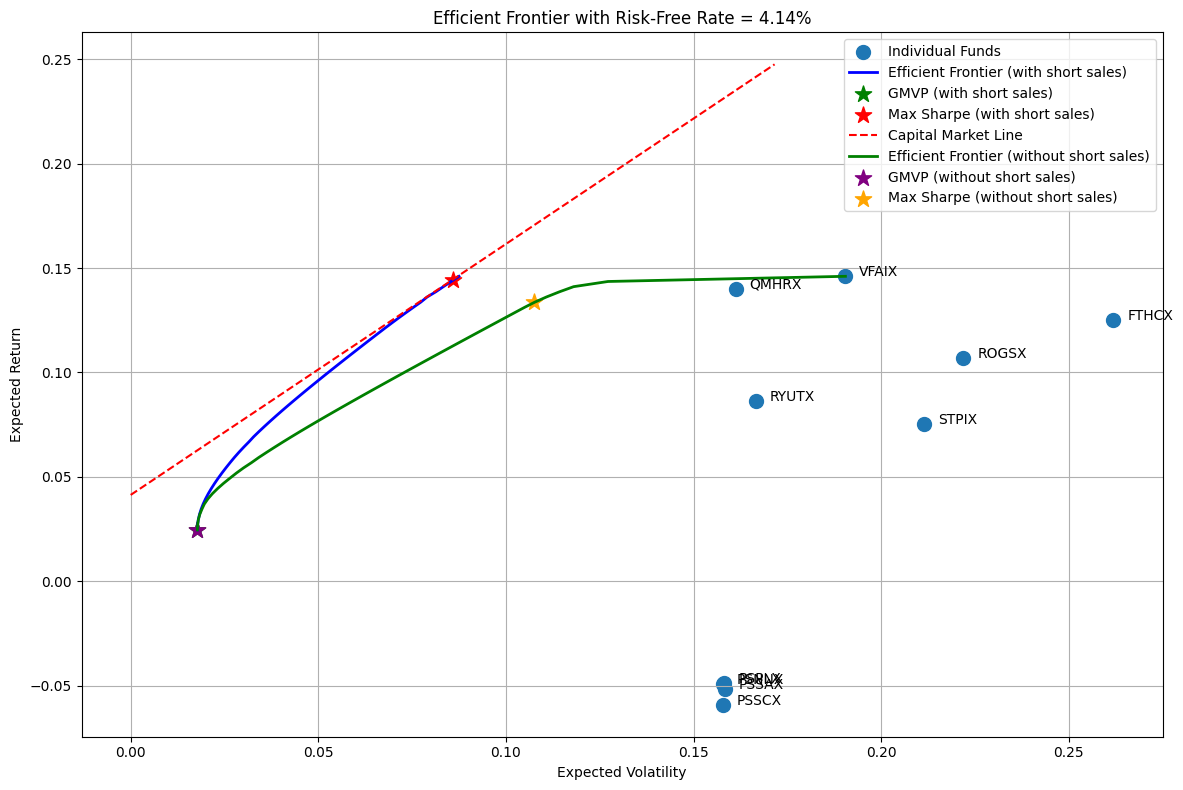

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
import os

# Create directories
os.makedirs('output', exist_ok=True)
os.makedirs('data', exist_ok=True)

def calculate_efficient_frontier():
    """
    Calculate the efficient frontier with and without short sales
    """
    # Load data from Chunk 1
    try:
        selected_funds = pd.read_csv('data/selected_funds.csv', header=None).iloc[:, 0].tolist()
        mean_returns = pd.read_csv('data/mean_returns.csv', index_col=0).iloc[:, 0]
        cov_matrix = pd.read_csv('data/cov_matrix.csv', index_col=0)
    except FileNotFoundError:
        print("Error: Data files not found. Please run Chunk 1 first.")
        return None
    
    # Get risk-free rate (3-month Treasury bill)
    try:
        risk_free_data = yf.download('^IRX', period='1d')
        if not risk_free_data.empty:
            # Make sure we're getting a float, not a Series
            risk_free_rate = float(risk_free_data['Close'].iloc[-1]) / 100  # Convert from percentage
        else:
            risk_free_rate = 0.035  # 3.5% default
    except:
        # Use default if unable to fetch
        risk_free_rate = 0.035  # 3.5%
    
    print(f"Using risk-free rate: {risk_free_rate:.2%}")
    
    # Portfolio performance functions
    def portfolio_performance(weights):
        returns = np.sum(mean_returns * weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (returns - risk_free_rate) / volatility
        return returns, volatility, sharpe
    
    def negative_sharpe(weights):
        return -portfolio_performance(weights)[2]
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights)[1]
    
    # Calculate efficient frontier points with short sales
    def calculate_frontier_points(allow_short=True):
        num_assets = len(mean_returns)
        
        # Minimum volatility portfolio
        bounds = tuple((-1, 1) if allow_short else (0, 1) for _ in range(num_assets))
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        # Get min volatility portfolio
        result_min_vol = minimize(
            portfolio_volatility, 
            np.array([1/num_assets] * num_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        min_vol_weights = result_min_vol['x']
        min_vol_return, min_vol_volatility, min_vol_sharpe = portfolio_performance(min_vol_weights)
        
        # Get max Sharpe portfolio
        result_max_sharpe = minimize(
            negative_sharpe, 
            np.array([1/num_assets] * num_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        max_sharpe_weights = result_max_sharpe['x']
        max_sharpe_return, max_sharpe_volatility, max_sharpe_sharpe = portfolio_performance(max_sharpe_weights)
        
        # Generate frontier points
        target_returns = np.linspace(min_vol_return, max(mean_returns), 50)
        efficient_list = []
        
        for target in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target}
            ]
            
            result = minimize(
                portfolio_volatility, 
                np.array([1/num_assets] * num_assets),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints
            )
            
            if result['success']:
                ef_weights = result['x']
                ef_return, ef_volatility, ef_sharpe = portfolio_performance(ef_weights)
                efficient_list.append((ef_return, ef_volatility, ef_sharpe, ef_weights))
        
        returns = [r for r, v, s, w in efficient_list]
        volatilities = [v for r, v, s, w in efficient_list]
        
        return {
            'returns': returns,
            'volatilities': volatilities,
            'min_vol': (min_vol_return, min_vol_volatility, min_vol_sharpe, min_vol_weights),
            'max_sharpe': (max_sharpe_return, max_sharpe_volatility, max_sharpe_sharpe, max_sharpe_weights)
        }
    
    # Calculate efficient frontiers
    print("Calculating efficient frontier with short sales...")
    ef_short = calculate_frontier_points(allow_short=True)
    
    print("Calculating efficient frontier without short sales...")
    ef_no_short = calculate_frontier_points(allow_short=False)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    
    # Plot individual funds
    fund_returns = np.array(mean_returns)
    fund_volatilities = np.array([np.sqrt(cov_matrix.iloc[i, i]) for i in range(len(selected_funds))])
    plt.scatter(fund_volatilities, fund_returns, marker='o', s=100, label='Individual Funds')
    
    # Add fund labels
    for i, fund in enumerate(selected_funds):
        plt.annotate(fund, (fund_volatilities[i], fund_returns[i]), 
                    xytext=(10, 0), textcoords='offset points')
    
    # Plot efficient frontier with short sales
    plt.plot(ef_short['volatilities'], ef_short['returns'], 'b-', linewidth=2, 
            label='Efficient Frontier (with short sales)')
    
    # Plot min vol and max Sharpe portfolios (with short sales)
    plt.scatter(ef_short['min_vol'][1], ef_short['min_vol'][0], s=150, color='g', marker='*', 
               label='GMVP (with short sales)')
    plt.scatter(ef_short['max_sharpe'][1], ef_short['max_sharpe'][0], s=150, color='r', marker='*', 
               label='Max Sharpe (with short sales)')
    
    # Plot Capital Market Line
    cml_x = np.array([0, ef_short['max_sharpe'][1], ef_short['max_sharpe'][1]*2])
    cml_y = np.array([risk_free_rate, ef_short['max_sharpe'][0], 
                      2*ef_short['max_sharpe'][0]-risk_free_rate])
    plt.plot(cml_x, cml_y, 'r--', label='Capital Market Line')
    
    # Plot efficient frontier without short sales
    plt.plot(ef_no_short['volatilities'], ef_no_short['returns'], 'g-', linewidth=2, 
            label='Efficient Frontier (without short sales)')
    
    # Plot min vol and max Sharpe portfolios (without short sales)
    plt.scatter(ef_no_short['min_vol'][1], ef_no_short['min_vol'][0], s=150, color='purple', marker='*', 
               label='GMVP (without short sales)')
    plt.scatter(ef_no_short['max_sharpe'][1], ef_no_short['max_sharpe'][0], s=150, color='orange', marker='*', 
               label='Max Sharpe (without short sales)')
    
    # Finalize the plot
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.title(f'Efficient Frontier with Risk-Free Rate = {risk_free_rate:.2%}')
    plt.legend()
    plt.savefig('output/efficient_frontier.png')
    plt.tight_layout()
    
    # Save key information for Chunk 3
    frontier_data = {
        'with_short': ef_short,
        'without_short': ef_no_short,
        'risk_free_rate': risk_free_rate,
        'selected_funds': selected_funds
    }
    
    # Save risk-free rate for later use
    with open('data/risk_free_rate.txt', 'w') as f:
        f.write(str(risk_free_rate))
    
    # Print key portfolio metrics
    print("\nKey Portfolio Metrics:")
    print("\nGlobal Minimum Variance Portfolio (with short sales):")
    print(f"Expected Return: {ef_short['min_vol'][0]:.4f}")
    print(f"Expected Volatility: {ef_short['min_vol'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_short['min_vol'][2]:.4f}")
    
    print("\nMaximum Sharpe Ratio Portfolio (with short sales):")
    print(f"Expected Return: {ef_short['max_sharpe'][0]:.4f}")
    print(f"Expected Volatility: {ef_short['max_sharpe'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_short['max_sharpe'][2]:.4f}")
    
    print("\nGlobal Minimum Variance Portfolio (without short sales):")
    print(f"Expected Return: {ef_no_short['min_vol'][0]:.4f}")
    print(f"Expected Volatility: {ef_no_short['min_vol'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_no_short['min_vol'][2]:.4f}")
    
    print("\nMaximum Sharpe Ratio Portfolio (without short sales):")
    print(f"Expected Return: {ef_no_short['max_sharpe'][0]:.4f}")
    print(f"Expected Volatility: {ef_no_short['max_sharpe'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_no_short['max_sharpe'][2]:.4f}")
    
    return frontier_data

if __name__ == "__main__":
    frontier_data = calculate_efficient_frontier()
    print("\nChunk 3 completed. Efficient frontier plot saved to 'output' directory.")